In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_recall_fscore_support
from xgboost import XGBClassifier

%matplotlib inline

In [2]:
df = pd.read_parquet("../features/training_set")
df = df.sample(frac=1.0, random_state=47).reset_index(drop=True)

In [3]:
df.head()

,race_year,race_name,driver_id,driver_nationality,team,lap_percent,position_gain,pit_stop_rate,rolling_avg_lap_time_3,lap_time_cv_3,qualifying_avg_sec,qualifying_delta,points,rolling_fatigue_score,position_change_rate_3,is_pole_position
0,2020,Styrian Grand Prix,830,Dutch,Red Bull,0.239437,0,8.352938,68.859998,0.000367,78.907997,2.550995,15.0,-6.267836,0,True
1,2020,Portuguese Grand Prix,817,Australian,Renault,0.569231,3,1.756756,83.161001,0.012472,77.550999,0.139999,2.0,-1.577974,1,False
2,2018,Mexican Grand Prix,20,German,Ferrari,0.971831,2,2.057971,80.057999,0.001082,75.591332,1.119003,18.0,-3.564775,0,True
3,2018,United States Grand Prix,843,New Zealander,Toro Rosso,0.327273,9,3.055555,102.529335,0.001676,95.205992,0.000000,2.0,-3.754922,0,False
4,2013,Chinese Grand Prix,8,Finnish,Lotus F1,0.964286,0,3.111111,100.174665,0.001467,95.821998,2.285004,18.0,-3.485187,1,True


In [4]:
df.shape

(103663, 16)

In [5]:
# drop the meta data columns
df = df.drop(['race_year', 'race_name', 'driver_id', 'driver_nationality', 'team'], axis=1)

In [6]:
df.columns

Index(['lap_percent', 'position_gain', 'pit_stop_rate',
       'rolling_avg_lap_time_3', 'lap_time_cv_3', 'qualifying_avg_sec',
       'qualifying_delta', 'points', 'rolling_fatigue_score',
       'position_change_rate_3', 'is_pole_position'],
      dtype='object')

In [7]:
df.shape

(103663, 11)

In [8]:
# check the null counts
df.isnull().mean() * 100

lap_percent               0.000000
position_gain             0.000000
pit_stop_rate             0.000000
rolling_avg_lap_time_3    0.000000
lap_time_cv_3             0.000000
qualifying_avg_sec        0.000000
qualifying_delta          0.492943
points                    0.000000
rolling_fatigue_score     0.000000
position_change_rate_3    0.000000
is_pole_position          0.000000
dtype: float64

In [9]:
# df[df['qualifying_delta'].isnull()]

In [10]:
# 95th percentile of qualifying_delta (excluding nulls)
qdelta_95 = np.nanpercentile(df['qualifying_delta'], 95)
qdelta_95

np.float32(10.782005)

* We impute missing `qualifying_delta` values using the 95th percentile to realistically reflect unstable or poor qualifying performances, aligning with race dynamics where missing or incomplete qualifying usually indicates extreme inconsistency rather than average behavior.

In [11]:
df['qualifying_delta'] = df['qualifying_delta'].fillna(qdelta_95)

In [12]:
# change the dtype of target from bool to int
df['is_pole_position'] = df['is_pole_position'].astype(int)

In [13]:
df.head()

,lap_percent,position_gain,pit_stop_rate,rolling_avg_lap_time_3,lap_time_cv_3,qualifying_avg_sec,qualifying_delta,points,rolling_fatigue_score,position_change_rate_3,is_pole_position
0,0.239437,0,8.352938,68.859998,0.000367,78.907997,2.550995,15.0,-6.267836,0,1
1,0.569231,3,1.756756,83.161001,0.012472,77.550999,0.139999,2.0,-1.577974,1,0
2,0.971831,2,2.057971,80.057999,0.001082,75.591332,1.119003,18.0,-3.564775,0,1
3,0.327273,9,3.055555,102.529335,0.001676,95.205992,0.000000,2.0,-3.754922,0,0
4,0.964286,0,3.111111,100.174665,0.001467,95.821998,2.285004,18.0,-3.485187,1,1


In [14]:
X = df.drop(['is_pole_position'], axis=1)
y = df['is_pole_position']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                            X, y, 
                            test_size=0.33, 
                            random_state=47,
                            stratify=y
                        )

In [16]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((69454, 10), (34209, 10), (69454,), (34209,))

In [17]:
y_train.value_counts(normalize=True) * 100

is_pole_position
0    66.515967
1    33.484033
Name: proportion, dtype: float64

In [18]:
y_test.value_counts(normalize=True) * 100

is_pole_position
0    66.517583
1    33.482417
Name: proportion, dtype: float64

In [19]:
X_train.head()

,lap_percent,position_gain,pit_stop_rate,rolling_avg_lap_time_3,lap_time_cv_3,qualifying_avg_sec,qualifying_delta,points,rolling_fatigue_score,position_change_rate_3
96628,0.363636,3,8.249998,90.604668,0.004199,83.715334,0.790001,15.0,-5.290808,0
30098,0.924528,1,2.163265,87.431000,0.002371,84.695995,0.213997,2.0,-2.554510,1
3522,0.590909,2,6.769230,89.818331,0.003879,83.338000,1.069000,12.0,-4.247231,0
93253,0.449275,-3,2.225806,90.728002,0.148877,76.185661,0.896996,2.0,3.784337,-3
83765,0.676923,4,2.954545,87.262332,0.003723,81.656002,0.570000,6.0,-3.078457,0


In [20]:
# select features to scale and features to keep as it is
features_to_scale = [
    'pit_stop_rate',
    'rolling_avg_lap_time_3',
    'lap_time_cv_3',
    'qualifying_avg_sec',
    'qualifying_delta',
    'points',
    'rolling_fatigue_score'
]

features_to_keep = [
    'lap_percent',
    'position_gain', 
    'position_change_rate_3'
]

In [21]:
# help(ColumnTransformer)

In [22]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), features_to_keep),
        ('keep', 'passthrough', features_to_keep)
    ]
)

pipeline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(
            eval_metric='logloss', 
            scale_pos_weight=1.9865,
            random_state=47))
    ]
)

In [23]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['lap_percent',
                                                   'position_gain',
                                                   'position_change_rate_3']),
                                                 ('keep', 'passthrough',
                                                  ['lap_percent',
                                                   'position_gain',
                                                   'position_change_rate_3'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               co...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=47, ...))])

In [24]:
train_score = pipeline.score(X_train, y_train)
train_score

0.6673769689290754

In [25]:
test_score = pipeline.score(X_test, y_test)
test_score

0.6460580548978339

In [26]:
y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

In [27]:
print("Classification Report Train Set:\n", classification_report(y_train, y_train_pred))

Classification Report Train Set:
               precision    recall  f1-score   support

           0       0.83      0.63      0.72     46198
           1       0.50      0.74      0.60     23256

    accuracy                           0.67     69454
   macro avg       0.66      0.69      0.66     69454
weighted avg       0.72      0.67      0.68     69454



In [28]:
print("Classification Report Test Set:\n", classification_report(y_test, y_test_pred))

Classification Report Test Set:
               precision    recall  f1-score   support

           0       0.81      0.61      0.70     22755
           1       0.48      0.71      0.57     11454

    accuracy                           0.65     34209
   macro avg       0.64      0.66      0.64     34209
weighted avg       0.70      0.65      0.66     34209



In [29]:


def plot_roc_curve(model, X_test, y_test):
    """
    Plots the ROC-AUC curve for a given model and test set.
    
    Args:
        model: Trained model (must have predict_proba method).
        X_test: Features of test set.
        y_test: True labels of test set.
    """
    # Predict probabilities
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        raise ValueError("Model does not support probability prediction.")

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    
    # Plot
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC-AUC Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()


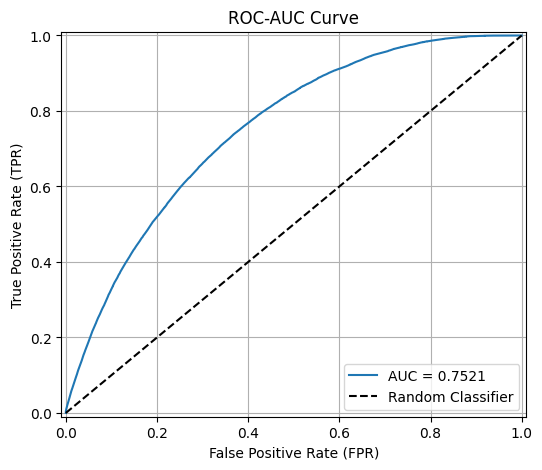

In [30]:
# train set
plot_roc_curve(pipeline, X_train, y_train)

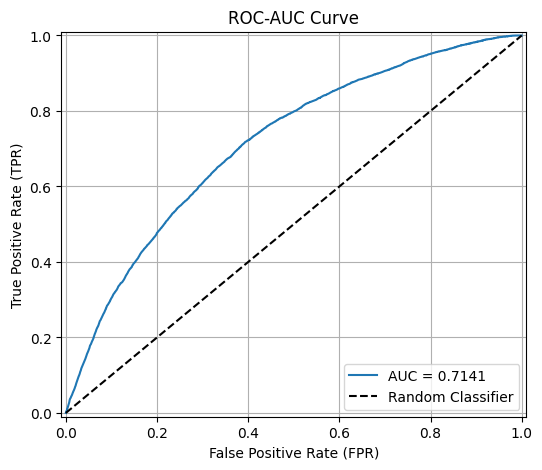

In [31]:
# test set
plot_roc_curve(pipeline, X_test, y_test)

In [32]:
pd.Series(y_train_pred).value_counts(normalize=True)

0    0.507617
1    0.492383
Name: proportion, dtype: float64

In [33]:
pd.Series(y_test_pred).value_counts(normalize=True)

0    0.505861
1    0.494139
Name: proportion, dtype: float64

In [34]:
param_grid = {
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__subsample': [0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.5],
    'classifier__min_child_weight': [1, 3, 5, 7]
}


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=47)


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=60,  # Try 30 random combinations
    scoring='f1',  # Focus on f1-score
    cv=cv,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Parallel processing
)

# 9. Fit the Search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=47, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('scale',
                                                                               StandardScaler(),
                                                                               ['lap_percent',
                                                                                'position_gain',
                                                                                'position_change_rate_3']),
                                                                              ('keep',
                                                                               'passthrough',
                                                                               ['lap_percent',
                                                                                'position_gain',
                                                                                'position_change_rate_3'])])),
                                             ('classifier',
                                              XGBClassifier(ba...
                   param_distributions={'classifier__colsample_bytree': [0.7,
                                                                         0.8,
                                                                         0.9,
                                                                         1.0],
                                        'classifier__gamma': [0, 0.1, 0.2, 0.5],
                                        'classifier__learning_rate': [0.01,
                                                                      0.05, 0.1,
                                                                      0.2],
                                        'classifier__max_depth': [3, 5, 7, 9],
                                        'classifier__min_child_weight': [1, 3,
                                                                         5, 7],
                                        'classifier__n_estimators': [100, 300,
                                                                     500],
                                        'classifier__subsample': [0.7, 0.8, 0.9,
                                                                  1.0]},
                   random_state=42, scoring='f1', verbose=2)

In [35]:
print("✅ Best Parameters Found:")
print(random_search.best_params_)

✅ Best Parameters Found:
{'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__min_child_weight': 5, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0, 'classifier__colsample_bytree': 0.9}


In [36]:
# Predict
y_train_pred_best = random_search.predict(X_train)
y_test_pred_best = random_search.predict(X_test)

In [37]:
# Classification report
print("📋 Classification Report on Train Set (After Tuning):")
print(classification_report(y_train, y_train_pred_best))

📋 Classification Report on Train Set (After Tuning):
              precision    recall  f1-score   support

           0       0.82      0.60      0.69     46198
           1       0.48      0.74      0.58     23256

    accuracy                           0.65     69454
   macro avg       0.65      0.67      0.64     69454
weighted avg       0.71      0.65      0.66     69454



In [38]:
# Classification report
print("📋 Classification Report on Test Set (After Tuning):")
print(classification_report(y_test, y_test_pred_best))

📋 Classification Report on Test Set (After Tuning):
              precision    recall  f1-score   support

           0       0.81      0.59      0.69     22755
           1       0.48      0.73      0.58     11454

    accuracy                           0.64     34209
   macro avg       0.64      0.66      0.63     34209
weighted avg       0.70      0.64      0.65     34209



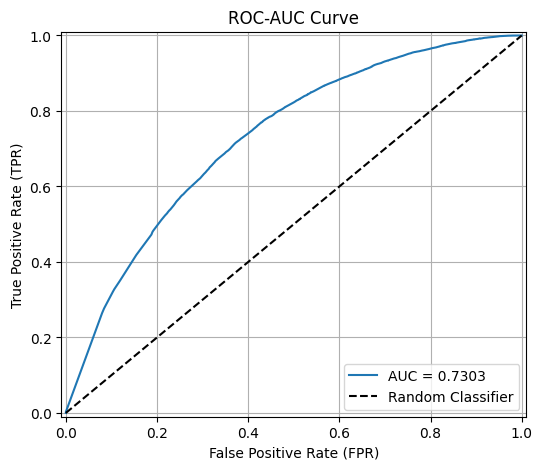

In [39]:
# plot after tuning
plot_roc_curve(random_search, X_train, y_train)

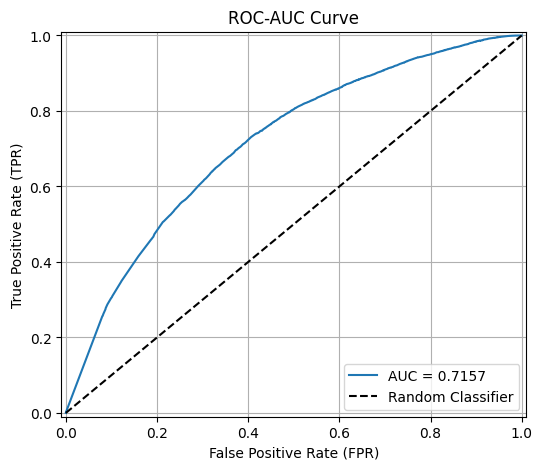

In [40]:
plot_roc_curve(random_search, X_test, y_test)

In [50]:
import optuna

def objective(trial):
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.3, 2.2),
        'random_state': 47,
        'eval_metric': 'logloss'
    }
    
    # Define model inside objective
    model = XGBClassifier(**params)

    # Build pipeline
    from sklearn.pipeline import Pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Fit model
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Return F1-score for class 1
    return f1_score(y_test, y_pred, pos_label=1)

In [51]:
study = optuna.create_study(direction='maximize')

# Start optimization
study.optimize(objective, n_trials=50)

[I 2025-04-29 02:44:19,751] A new study created in memory with name: no-name-4e372e68-4aa1-431e-a546-f8174c34ee46
[I 2025-04-29 02:44:21,184] Trial 0 finished with value: 0.5664223385689354 and parameters: {'n_estimators': 446, 'max_depth': 6, 'learning_rate': 0.2884000834393625, 'subsample': 0.8452753706271153, 'colsample_bytree': 0.8142426166854752, 'gamma': 0.40308867650536645, 'min_child_weight': 10, 'scale_pos_weight': 2.039131883632787}. Best is trial 0 with value: 0.5664223385689354.
[I 2025-04-29 02:44:23,223] Trial 1 finished with value: 0.5588301126613445 and parameters: {'n_estimators': 597, 'max_depth': 7, 'learning_rate': 0.1230125963715528, 'subsample': 0.9579114663803678, 'colsample_bytree': 0.9807534412634583, 'gamma': 0.21921115157772708, 'min_child_weight': 3, 'scale_pos_weight': 1.81419431454461}. Best is trial 0 with value: 0.5664223385689354.
[I 2025-04-29 02:44:24,633] Trial 2 finished with value: 0.5369244858879361 and parameters: {'n_estimators': 472, 'max_depth

In [52]:
print("✅ Best Hyperparameters Found by Optuna:")
print(study.best_params)

✅ Best Hyperparameters Found by Optuna:
{'n_estimators': 321, 'max_depth': 4, 'learning_rate': 0.0740354172393713, 'subsample': 0.7245317486190462, 'colsample_bytree': 0.6926275506803605, 'gamma': 0.44983315063610546, 'min_child_weight': 4, 'scale_pos_weight': 2.12671411396284}


In [54]:
final_model = XGBClassifier(
    **study.best_params
)

final_pipeline = Pipeline([
    ('preprocessor', preprocessor), 
    ('classifier', final_model)
])


final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['lap_percent',
                                                   'position_gain',
                                                   'position_change_rate_3']),
                                                 ('keep', 'passthrough',
                                                  ['lap_percent',
                                                   'position_gain',
                                                   'position_change_rate_3'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               co...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.0740354172393713, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=4,
                               max_leaves=None, min_child_weight=4, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=321, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [55]:
# Predict
y_train_pred_final = final_pipeline.predict(X_train)
y_test_pred_final = final_pipeline.predict(X_test)

In [56]:
# Classification report
print("📋 Classification Report on Train Set (After Optuna Search):")
print(classification_report(y_train, y_train_pred_final))

📋 Classification Report on Train Set (After Optuna Search):
              precision    recall  f1-score   support

           0       0.82      0.60      0.69     46198
           1       0.48      0.75      0.59     23256

    accuracy                           0.65     69454
   macro avg       0.65      0.67      0.64     69454
weighted avg       0.71      0.65      0.66     69454



In [57]:
# Classification report
print("📋 Classification Report on Test Set (After Optuna Search):")
print(classification_report(y_test, y_test_pred_final))

📋 Classification Report on Test Set (After Optuna Search):
              precision    recall  f1-score   support

           0       0.82      0.59      0.68     22755
           1       0.47      0.74      0.58     11454

    accuracy                           0.64     34209
   macro avg       0.64      0.66      0.63     34209
weighted avg       0.70      0.64      0.65     34209



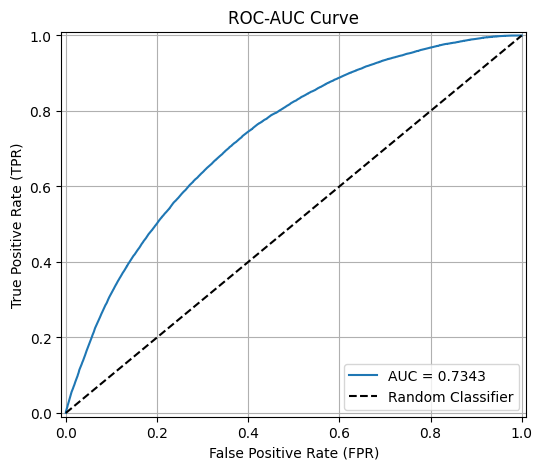

In [58]:
# plot 
plot_roc_curve(final_pipeline, X_train, y_train)

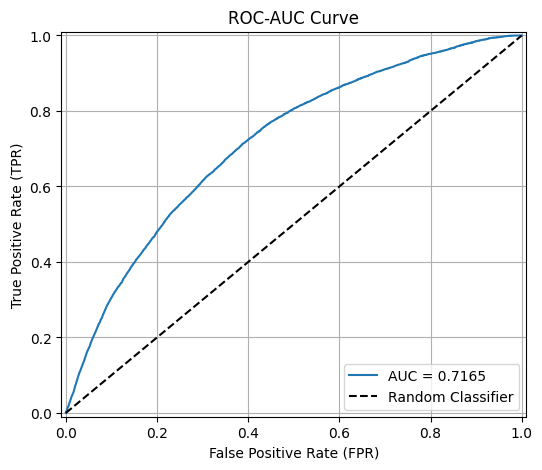

In [59]:
plot_roc_curve(final_pipeline, X_test, y_test)

In [61]:
# 1. Predict probabilities
y_probs = final_pipeline.predict_proba(X_test)[:, 1]

# 2. Define threshold range
thresholds = np.arange(0.3, 0.65, 0.02)  # 0.30 to 0.64 with step 0.02

# 3. Store metrics
precision_list = []
recall_list = []
f1_list = []

# 4. Calculate metrics at each threshold
for threshold in thresholds:
    y_pred_thresh = (y_probs >= threshold).astype(int)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_test, y_pred_thresh, pos_label=1, average='binary'
    )
    precision_list.append(precision)
    recall_list.append(recall)
    f1_list.append(f1)

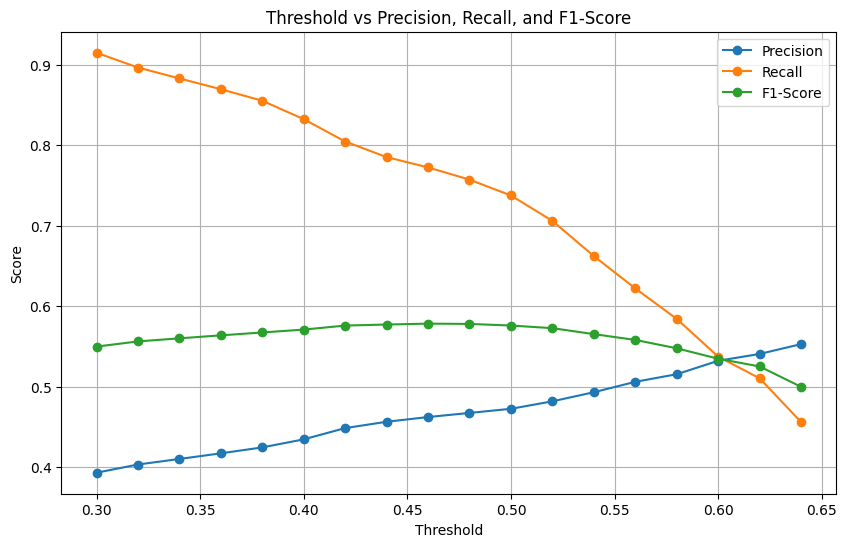

In [62]:
# 5. Plot
plt.figure(figsize=(10,6))
plt.plot(thresholds, precision_list, label='Precision', marker='o')
plt.plot(thresholds, recall_list, label='Recall', marker='o')
plt.plot(thresholds, f1_list, label='F1-Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold vs Precision, Recall, and F1-Score')
plt.legend()
plt.grid()
plt.show()

In [63]:
# 6. Find best threshold for F1
best_idx = np.argmax(f1_list)
best_threshold = thresholds[best_idx]

print(f"🏆 Best Threshold (Max F1): {best_threshold:.2f}")
print(f"F1 at Best Threshold: {f1_list[best_idx]:.4f}")

🏆 Best Threshold (Max F1): 0.46
F1 at Best Threshold: 0.5783
